# Выпускной проект: Телекоммуникации.

**Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.**

**Цель:** «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Задача** — обучить на предоставленных данных модель для прогноза оттока клиентов.

**Описание данных**
**Данные состоят из нескольких файлов, полученных из разных источников:**
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

**Для успешного выполнения поставленной задачи составим план действий:**
- Загрузить таблицы с данными и посмотреть на собержимое;
- Провести необходимую предобработку данных;
- Объединить таблицы, выделить целевой признак;
- Составить портрет ушедшего клиента;
- Разделить данные на тренировочную и тестовую выборки и обучить модели на тренировочном датасете;
- Сделать предсказание целевого признака на тестовом датасете лучшей моделью и посчитать метрики;
- Сделать вывод и дать рекомендации на основе имеющихся данных.

## Подготовка.

**Загрузим необходимые библиотеки и датасеты.**

In [1]:
!pip install phik -q

In [2]:
import warnings
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
contract_new = pd.read_csv('/datasets/contract_new.csv', parse_dates=[1, 2])
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

## Исследовательский анализ.

### Анализ таблицы contract_new.

In [4]:
contract_new.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [5]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


**При попытке изменить тип данных в столбце `TotalCharges` получил сообщение, что в данных есть значения с типом строка (пробел). Посмотрим, что это за строки.**

In [6]:
contract_new[contract_new['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


**Действительно, есть такие ячейки, что примечательно - это новые клиенты, которые еще не совершали оплаты, т.к данные нам предоставили как раз до 01-02-2020, данные по оплате просто не попали в эту таблицу. Заменим такие значения на 0.**

In [7]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].replace(' ', 0)
contract_new['TotalCharges'] = pd.to_numeric(contract_new['TotalCharges'])

In [8]:
contract_new.info()
print('Количество явных дубликатов:', contract_new.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
Количество явных дубликатов: 0


**Столбец `EndDate` содержит информацию об окончании действия договора. Это наш целевой параметр. Обработаем его, если даты нет, отметим, что клиент не ушел (статус 0), если дата есть, то отметим 1, клиент нас покинул. Получается задача классификации, где модели нужно научиться определять уйдет клиент (1) или нет (0)**

In [9]:
def end_date (date):
    if date == 'No':
        return 0
    return 1

In [10]:
contract_new['target'] = contract_new['EndDate'].apply(end_date)

In [11]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0


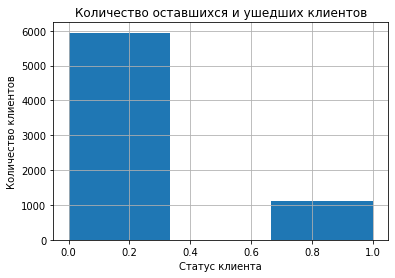

In [12]:
contract_new.target.hist(bins=3)
plt.xlabel('Статус клиента')
plt.ylabel('Количество клиентов')
plt.title('Количество оставшихся и ушедших клиентов');

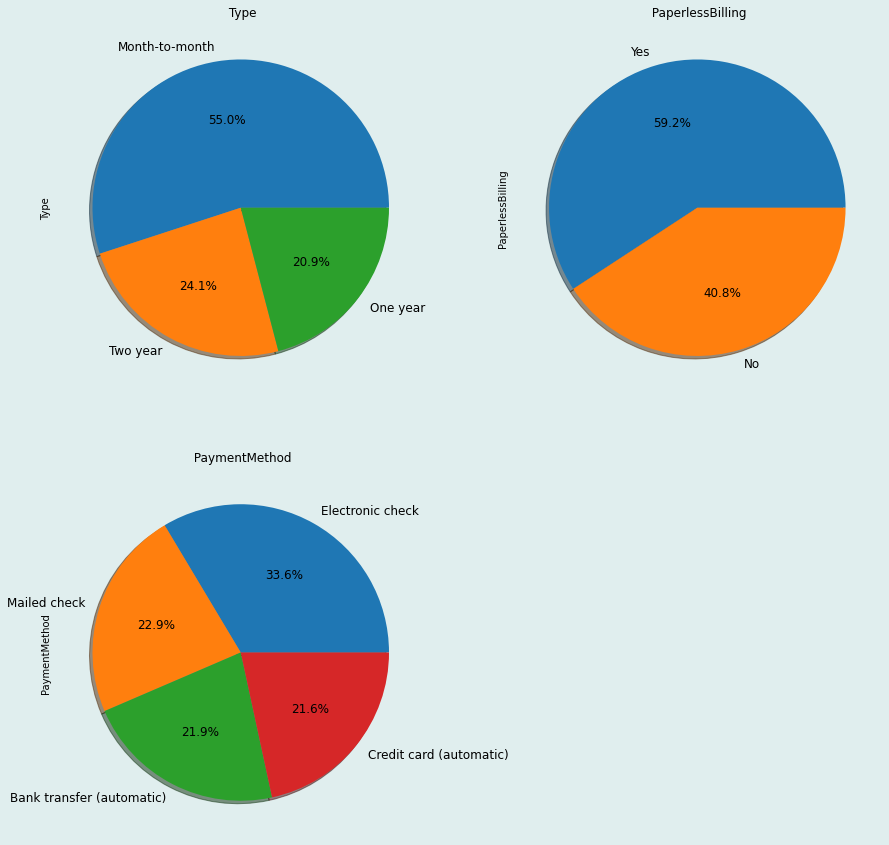

In [13]:
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod']
fig, axes = plt.subplots(nrows=2, ncols=2)
axe = axes.ravel()
for i, c in enumerate(cat_columns):
    contract_new[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title=' ' +str(c), 
                                      figsize=(15,15),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[3])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

In [14]:
print('Список уникальных значений.')
for col in (cat_columns):
    print(col, contract_new[col].unique())

Список уникальных значений.
Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


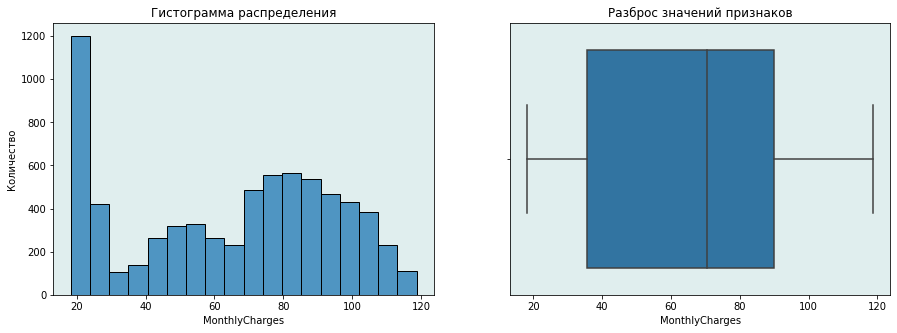

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


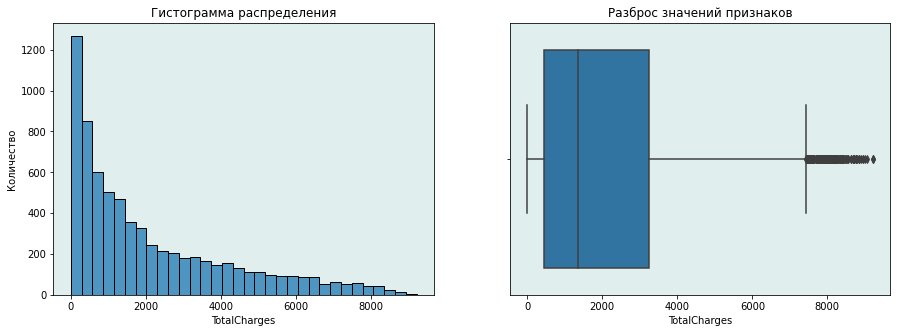

In [15]:
num_columns = contract_new.select_dtypes(include='float64').columns.tolist()
def hist_boxplot(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    sns.histplot(data=df, x=column, ax=axes[0], bins='auto')
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(column)
    axes[0].set_facecolor('#E0EEEE')
    
    sns.boxplot(contract_new[column], ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_facecolor('#E0EEEE')
      
    plt.show()
    
for column in list(num_columns):
    hist_boxplot(contract_new, column)

**Ежемесячные сборы составляют от 20 до 120 едениц, распределены мультимодально с пиками в отметках 20, 50 и 80 единиц, выбросов нет. Общие сборы показывают ненормальное распределение со смещением влево. Имеются выбросы, связанные с большими ежемесячными платежами и сроком пользования услугами.**

**Дубликатов нет, пропусков нет, пробелов вместо значений не осталось. Переименуем столбцы по общепринятым правилам.**

In [16]:
contract_new.rename(columns={'customerID': 'customer_id', 
                             'BeginDate': 'begin_date', 
                             'Type': 'type', 
                             'PaperlessBilling': 'paperless_billing', 
                             'PaymentMethod': 'payment_method', 
                             'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'}, inplace=True)

### Анализ таблицы personal_new.

In [17]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [18]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
print('Количество явных дубликатов:', personal_new.duplicated().sum())

Количество явных дубликатов: 0


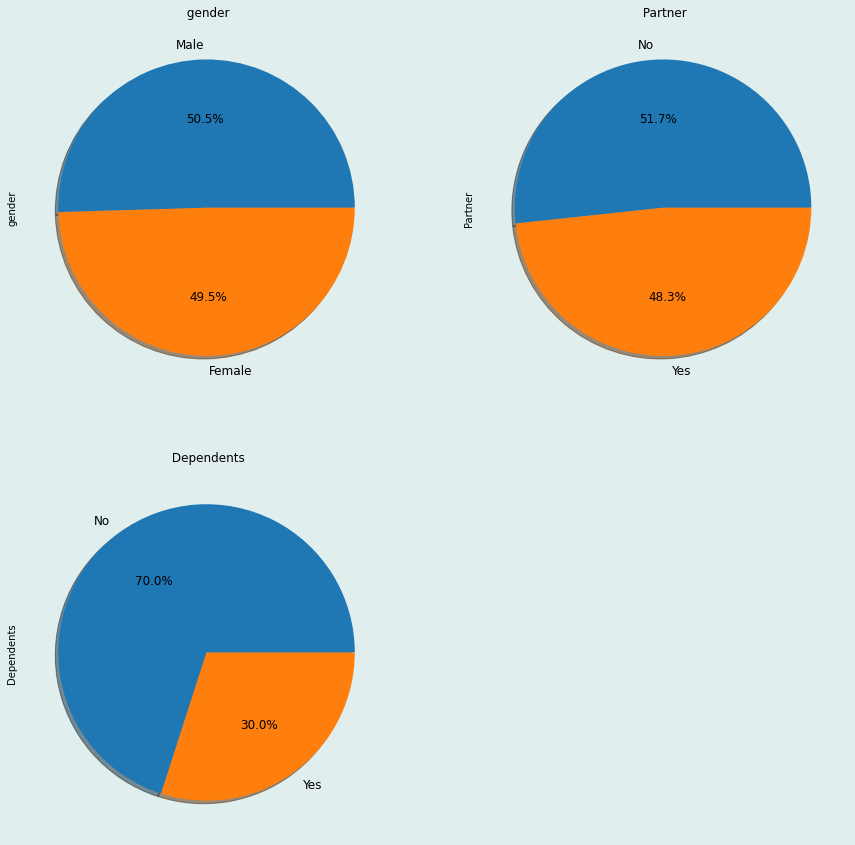

In [20]:
cat_columns_pers = ['gender', 'Partner', 'Dependents']
fig, axes = plt.subplots(nrows=2, ncols=2)
axe = axes.ravel()
for i, c in enumerate(cat_columns_pers):
    personal_new[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title=' ' +str(c), 
                                      figsize=(15,15),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[3])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

In [21]:
print('Список уникальных значений.')
for col in (cat_columns_pers):
    print(col, personal_new[col].unique())

Список уникальных значений.
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']


**Дубликатов нет, пропусков нет, пробелов вместо значений не осталось. Переименуем столбцы по общепринятым правилам.**

In [22]:
personal_new.rename(columns={'customerID': 'customer_id', 
                             'SeniorCitizen': 'senior_citizen', 
                             'Partner': 'partner', 
                             'Dependents': 'dependents'}, inplace=True)

In [23]:
personal_new.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**С таблицей `personal_new` все в порядке. Посмотрим следующую таблицу.** 

### Анализ таблицы internet_new.

In [24]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Вот и первая проблема: количество строк в датафрейме меньше чем в двух предыдущих.**

In [26]:
print('Количество явных дубликатов:', internet_new.duplicated().sum())

Количество явных дубликатов: 0


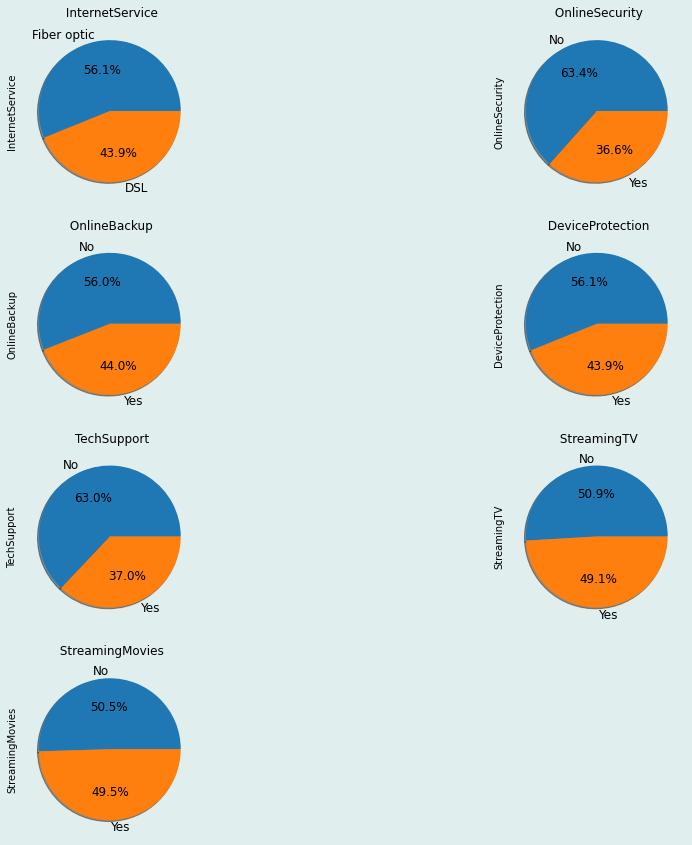

In [27]:
cat_columns_int = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
fig, axes = plt.subplots(nrows=4, ncols=2)
axe = axes.ravel()
for i, c in enumerate(cat_columns_int):
    internet_new[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title=' ' +str(c), 
                                      figsize=(16,15),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[7])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

In [28]:
print('Список уникальных значений.')
for col in (cat_columns_int):
    print(col, internet_new[col].unique())

Список уникальных значений.
InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


**Дубликатов нет, пропусков нет, пробелов вместо значений не осталось. Переименуем столбцы по общепринятым правилам.**

In [29]:
internet_new.rename(columns={'customerID': 'customer_id', 
                             'InternetService': 'internet_service', 
                             'OnlineSecurity': 'online_security', 
                             'OnlineBackup': 'online_backup', 
                             'DeviceProtection': 'device_protection', 
                             'TechSupport': 'tech_support', 
                             'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'}, inplace=True)

In [30]:
internet_new.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Осталось разобраться с количеством строк.**

### Анализ таблицы phone_new.

In [31]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [32]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Тут тоже строк меньше, чем в первых двух датасетах, но больше, чем в третьем.**

In [33]:
print('Количество явных дубликатов:', phone_new.duplicated().sum())

Количество явных дубликатов: 0


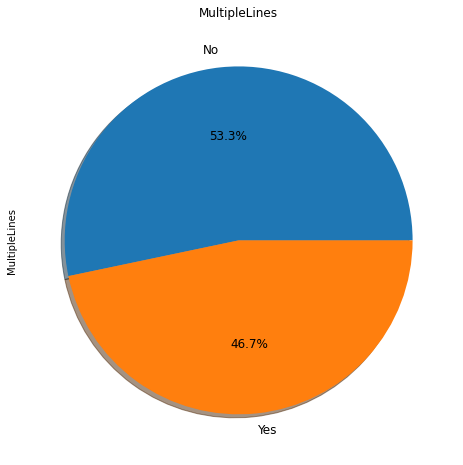

In [34]:
phone_new['MultipleLines'].value_counts().plot(kind='pie', 
                                    shadow = True, 
                                    autopct = '%1.1f%%', 
                                    title='MultipleLines', 
                                    figsize=(8,8),
                                    fontsize=12);

In [35]:
print('Список уникальных значений.')
print(phone_new['MultipleLines'].unique())

Список уникальных значений.
['No' 'Yes']


**Дубликатов нет, пропусков нет, пробелов вместо значений не осталось. Переименуем столбцы по общепринятым правилам.**

In [36]:
phone_new.rename(columns={'customerID': 'customer_id', 
                             'MultipleLines': 'multiple_lines'}, inplace=True)

In [37]:
phone_new.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Осталось разобраться с количеством строк.**

### Вывод.

**Посмотрели предложенные таблицы, заполнили пропуски в виде пробелов, дубликатов не обнаружили. С данными все в порядке. В таблицах `internet_new` и `phone_new` строк меньше, чем в таблице `contract_new` это может быть связано с тем, что у клиента не подключен интернет или телефон, поэтому и данные по нему не заполнялись. После объединения таблиц в одну придется заполнять пропуски.**

## Объединение данных

In [38]:
contract_new = contract_new.merge(personal_new, on='customer_id', how='left')
contract_new = contract_new.merge(internet_new, on='customer_id', how='left')
df = contract_new.merge(phone_new, on='customer_id', how='left')

In [39]:
df.sample(10)

,customer_id,begin_date,EndDate,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3522,0969-RGKCU,2017-01-01,No,One year,No,Credit card (automatic),19.80,769.23,0,Male,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1076,4121-AGSIN,2015-04-01,2018-03-01,One year,Yes,Credit card (automatic),24.50,908.95,1,Female,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2845,9093-FPDLG,2019-03-01,No,Month-to-month,Yes,Electronic check,94.20,1139.82,0,Female,...,No,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,No
551,1352-HNSAW,2014-02-01,2017-07-01,Two year,Yes,Bank transfer (automatic),115.60,5023.98,1,Female,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5946,6261-RCVNS,2016-04-01,2017-03-01,One year,No,Credit card (automatic),73.90,812.90,1,Female,...,No,No,DSL,Yes,Yes,Yes,Yes,No,Yes,No
4870,5825-XJOCM,2016-02-01,No,One year,Yes,Bank transfer (automatic),64.40,3214.85,0,Male,...,No,Yes,DSL,Yes,Yes,Yes,No,No,No,Yes
4047,2434-EEVDB,2014-10-01,No,Two year,Yes,Credit card (automatic),94.60,6054.40,0,Female,...,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,No,Yes
5482,6289-CPNLD,2017-03-01,2017-10-01,One year,Yes,Mailed check,73.90,517.30,1,Male,...,Yes,Yes,DSL,No,No,Yes,Yes,Yes,Yes,No
7016,1471-GIQKQ,2020-01-01,No,Month-to-month,No,Electronic check,49.95,53.95,0,Female,...,No,No,DSL,No,Yes,No,No,No,No,No
3164,2603-HVKCG,2017-07-01,No,Month-to-month,Yes,Electronic check,101.40,3332.00,0,Male,...,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No


In [40]:
df.shape

(7043, 21)

**Объединение завершено успешно, клиентов не потеряли. Но теперь у нас появились пропуски в данных.**

## Исследовательский анализ и предобработка данных объединённого датафрейма.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   EndDate            7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

In [42]:
df = df.fillna('No')

**Пропуски в данных после объединения могут быть связаны с тем, что у клиента не подключен интернет или телефон, поэтому и данные по нему не заполнялись. Заполним возникшие пропуски значением `No`.**

In [44]:
df.loc[df['senior_citizen'] == 0, 'senior_citizen'] = 'No'
df.loc[df['senior_citizen'] == 1, 'senior_citizen'] = 'Yes'

In [45]:
def end_date_2 (date):
    if date == 'No':
        return datetime.date(2020,2,1)
    if date != 'No':
        return date

In [46]:
df['EndDate'] = df['EndDate'].apply(end_date_2).astype('datetime64[ns]')

In [47]:
df['use_days'] = (df['EndDate'] - df['begin_date']).dt.days

In [48]:
df.head(10)

,customer_id,begin_date,EndDate,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,use_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0,Female,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,Male,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0,Female,...,No,DSL,Yes,No,No,No,No,No,No,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0,Female,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1,Male,...,Yes,DSL,Yes,Yes,No,No,No,No,No,882


In [49]:
df['use_months'] = round(df['use_days']/30).astype('int')

In [50]:
def days_before_pay (row):
    if row['type'] == 'Month-to-month':
        return row['use_days'] % 30
    elif row['type'] == 'One year':
        return row['use_months'] % 12
    return row['use_months'] % 24

df['days_before_pay'] = df.apply(days_before_pay, axis=1)

In [51]:
df = df.set_index('customer_id').drop('EndDate', axis=1)
df.head()

,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,use_days,use_months,days_before_pay
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,No,Yes,...,No,Yes,No,No,No,No,No,31,1,1
5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,0,Male,No,No,...,Yes,No,Yes,No,No,No,No,1036,35,11
3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,No,No,...,Yes,Yes,No,No,No,No,No,123,4,3
7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,No,No,...,Yes,No,Yes,Yes,No,No,No,1371,46,10
9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,No,No,...,No,No,No,No,No,No,No,153,5,3


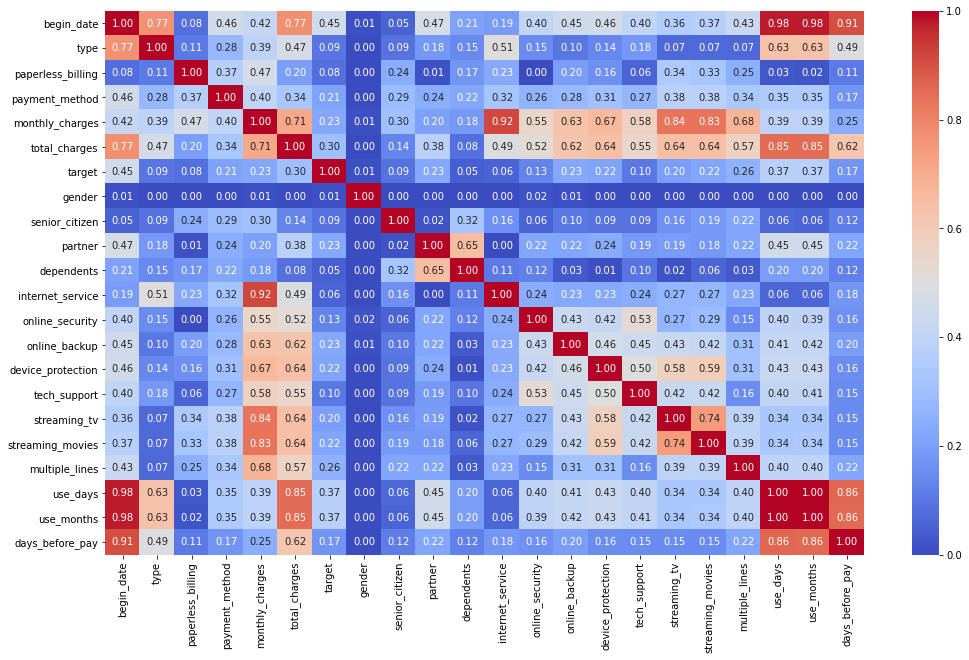

In [52]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 
                                          'target', 'use_days', 'use_months', 'days_before_pay']), 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm');

**Признак `gender` ни на что не влияет, его можно удалить. `use_day` И `begin_date` так же удалим из-за мультиколлинеарности. `monthly_charges` туда же. А признак `customer_id` переведем в индекс.**

In [53]:
df.drop(['begin_date'], axis=1, inplace=True)

In [54]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 4


**Провели исследовательский анализ данных после объединения таблиц, добавили 1 новый парамерт и убрали лишние. Дубликатов не появилось. Двигаемся дальше.**

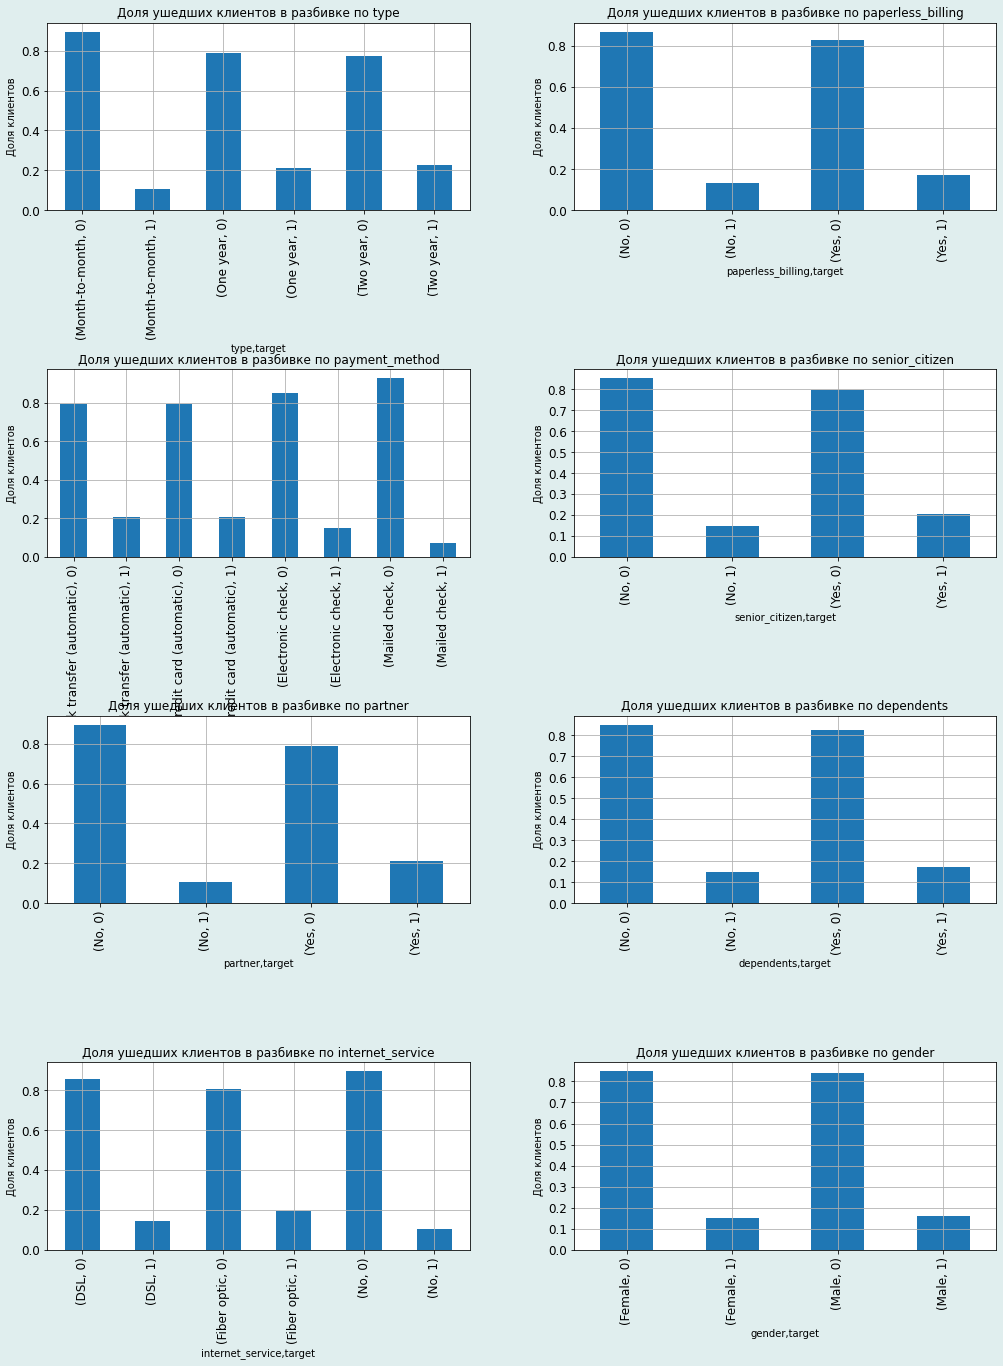

In [55]:
features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'gender']
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.tight_layout()
axe = axes.ravel()
for i, c in enumerate(features):
    df.groupby([c])['target'].value_counts(normalize=True).plot(kind='bar', 
                                      title='Доля ушедших клиентов в разбивке по ' +str(c),
                                      ylabel='Доля клиентов',
                                      grid=True,
                                      figsize=(15,20),
                                      fontsize=12,
                                      ax=axe[i])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

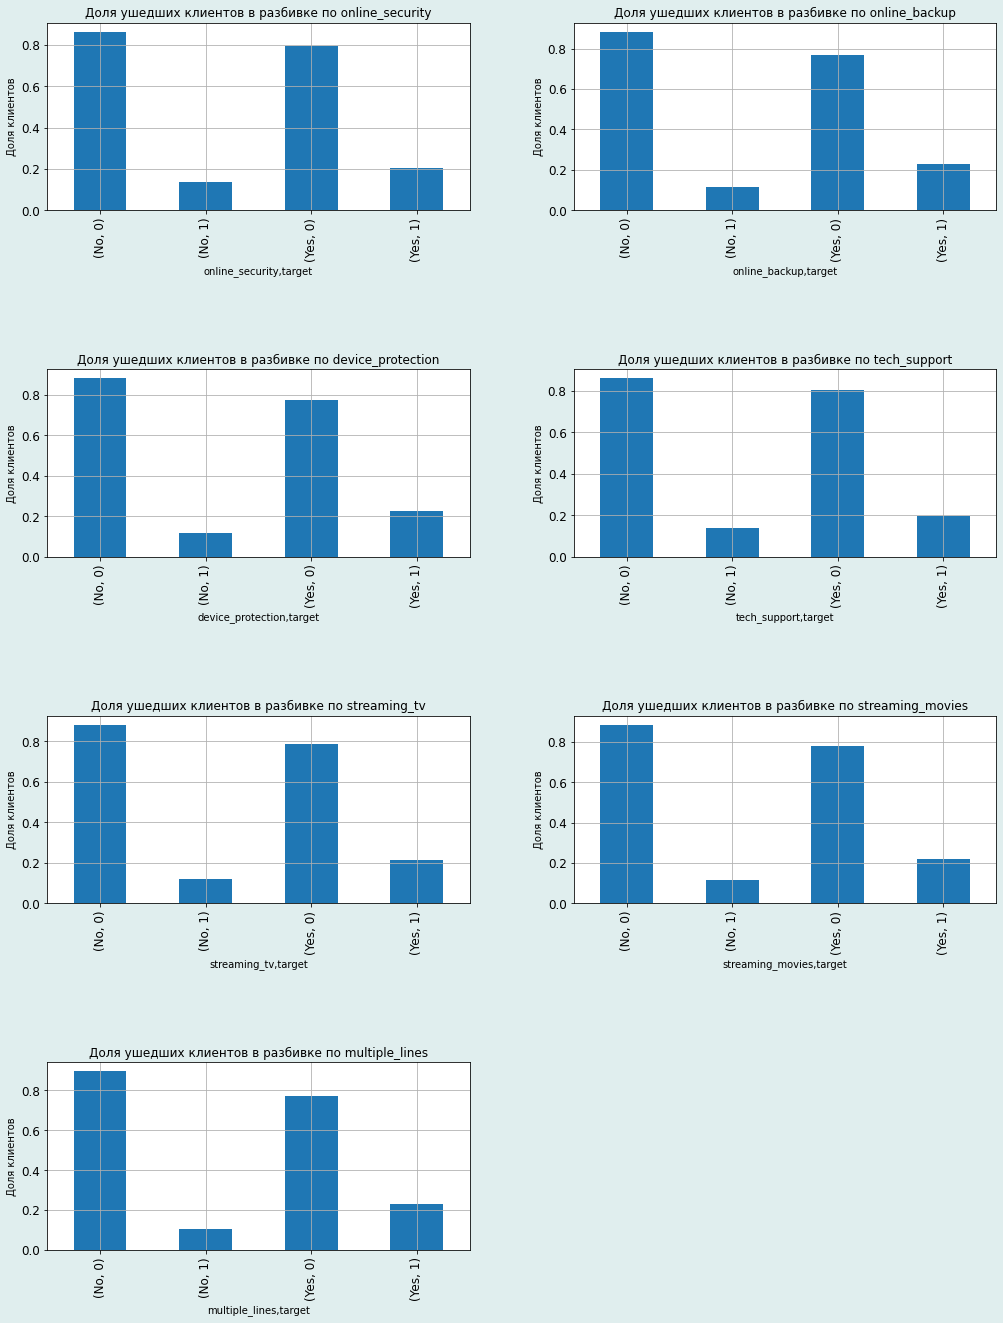

In [56]:
features = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.tight_layout()
axe = axes.ravel()
for i, c in enumerate(features):
    df.groupby([c])['target'].value_counts(normalize=True).plot(kind='bar', 
                                      title='Доля ушедших клиентов в разбивке по ' +str(c),
                                      ylabel='Доля клиентов',
                                      grid=True,
                                      figsize=(15,20),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[7])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

**Посмотрим на графики и увидим, что чаще всего расторгают договор клиенты с включенными дополнительными опциями и клиенты с договорной оплатой на 1 и 2 года.**

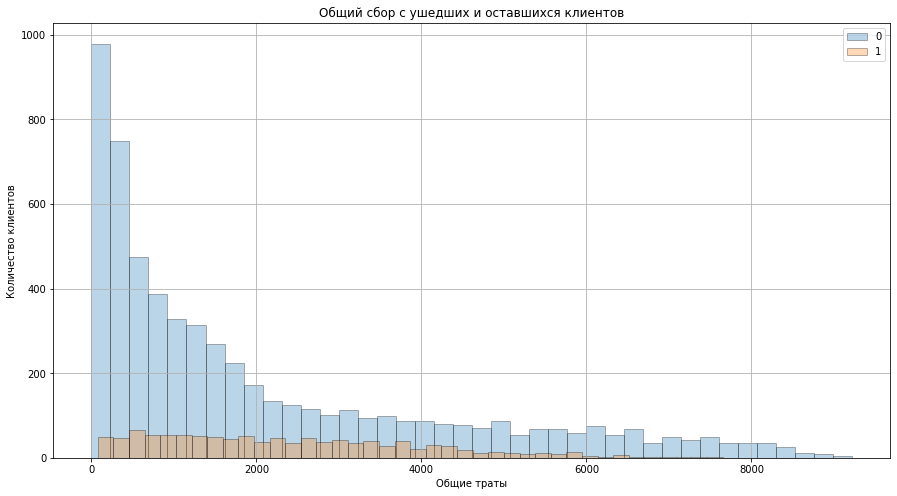

In [57]:
df.groupby('target')['total_charges'].plot(kind='hist', 
                                      bins=40, 
                                      grid=True, 
                                      edgecolor='black', 
                                      legend=True, 
                                      alpha=0.3, 
                                      figsize=(15,8));
plt.ylabel('Количество клиентов')
plt.xlabel('Общие траты')
plt.xticks(rotation = 0)
plt.title('Общий сбор с ушедших и оставшихся клиентов');
plt.show()


**Интересно, что количество ушедших клиентов практически не меняется до общих трат в 4200. Если на интервале от 0 до 2000 доля ушедших относительно невысокая, то от 2000 до 4200 почти половина клиентов уходит. Думаю, на этом стоит заострить внимание Телекома.**

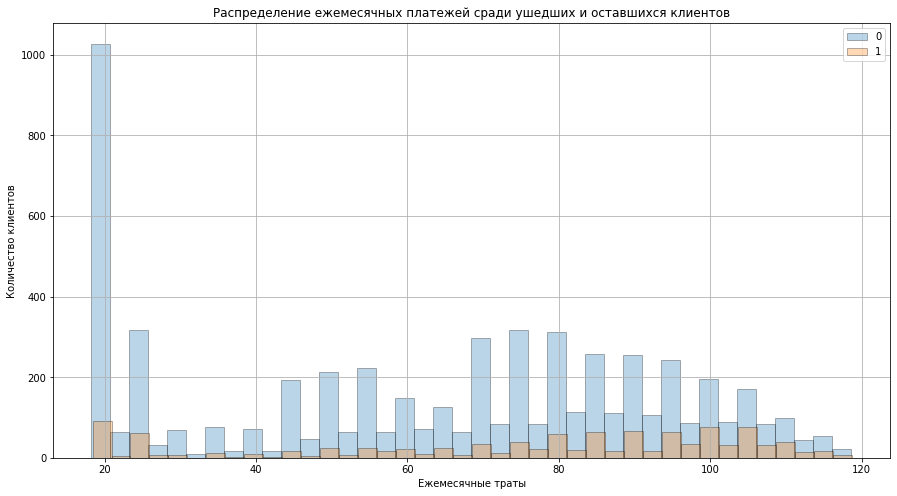

In [58]:
df.groupby('target')['monthly_charges'].plot(kind='hist', 
                                      bins=40, 
                                      grid=True, 
                                      edgecolor='black', 
                                      legend=True, 
                                      alpha=0.3, 
                                      figsize=(15,8));
plt.ylabel('Количество клиентов')
plt.xlabel('Ежемесячные траты')
plt.xticks(rotation = 0)
plt.title('Распределение ежемесячных платежей сради ушедших и оставшихся клиентов');
plt.show()

**Чем выше ежемесячная плата, тем выше вероятность ухода клиента.**

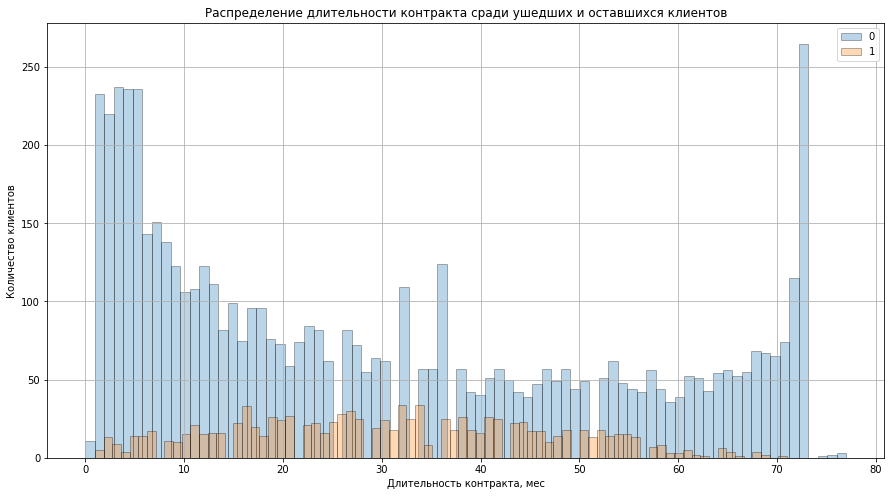

In [59]:
df.groupby('target')['use_months'].plot(kind='hist', 
                                      bins=80, 
                                      grid=True, 
                                      edgecolor='black', 
                                      legend=True, 
                                      alpha=0.3, 
                                      figsize=(15,8));
plt.ylabel('Количество клиентов')
plt.xlabel('Длительность контракта, мес')
plt.xticks(rotation = 0)
plt.title('Распределение длительности контракта сради ушедших и оставшихся клиентов');
plt.show()

**Похоже, что клиенты, пользующиеся услугами менее 3 лет чаще уходят, затем доля ушедших сокращается.**

## Подготовка данных.

In [60]:
features = df.drop(['target'], axis=1)
target = df['target']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 200524)

In [62]:
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'gender', \
              'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
num_columns = ['total_charges', 'monthly_charges', 'use_days', 'use_months', 'days_before_pay']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])
encoder_col_names = encoder.get_feature_names(ohe_columns)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)


In [63]:
X_train.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,...,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,total_charges,monthly_charges,use_days,use_months,days_before_pay
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.983192,-1.471425,-1.261537,-1.254783,-1.080815
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.315409,-0.376492,0.869956,0.881714,-0.931357
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.153797,0.308671,-0.327184,-0.339141,0.413770
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.951996,-1.166171,-1.172481,-1.167579,-0.931357
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,-0.031898,0.156044,-0.017679,-0.033927,-0.482981


In [64]:
X_test.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,...,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,total_charges,monthly_charges,use_days,use_months,days_before_pay
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.100439,0.068117,0.161892,0.184083,1.161062
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.960896,1.697244,1.891905,1.884560,-1.080815
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,-0.626284,0.477887,-0.903855,-0.905967,-0.333523
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.564911,-1.484697,0.738563,0.750908,1.908354
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,-0.769676,0.990515,-1.083426,-1.080375,-0.781898


## Обучение моделей машинного обучения.

### LogisticRegression

In [65]:
start_time = time.time()
model_lin = LogisticRegression(penalty='l1', solver='saga', random_state = 200524)
scores_lin = cross_val_score(model_lin, X_train, y_train, scoring='roc_auc', cv=5) 
final_score_linear = pd.Series(scores_lin).mean()
lr_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % lr_train_time)
roc_auc_lr_model = round(final_score_linear, 4)
print(f'Метрика на кросс-валидационной выборке:', roc_auc_lr_model)

---Время обучения модели 0.84489 секунд ---
Метрика на кросс-валидационной выборке: 0.775


### DecisionTreeClassifier

In [66]:

start_time = time.time()
pipe_final = Pipeline(
    [
        ('models', DecisionTreeClassifier(random_state=200524))
    ]
)

param_grid = [

    {
        'models__max_depth': range(1, 25),
        'models__max_features': range(1, 25),
        'models__min_samples_leaf': range(1, 25)
    }
]
rs = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, random_state=200524)

start_time = time.time()
rs.fit(X_train, y_train)
dtr_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % dtr_train_time)

roc_auc_model_tree = round((rs.best_score_), 4)


print(f'Метрика на кросс-валидационной выборке: {roc_auc_model_tree}')
print('Лучшая модель и её параметры:\n', rs.best_estimator_)

---Время обучения модели 0.72206 секунд ---
Метрика на кросс-валидационной выборке: 0.7853
Лучшая модель и её параметры:
 Pipeline(steps=[('models',
                 DecisionTreeClassifier(max_depth=8, max_features=16,
                                        min_samples_leaf=24,
                                        random_state=200524))])


**Посмотрим на важность признаков.**

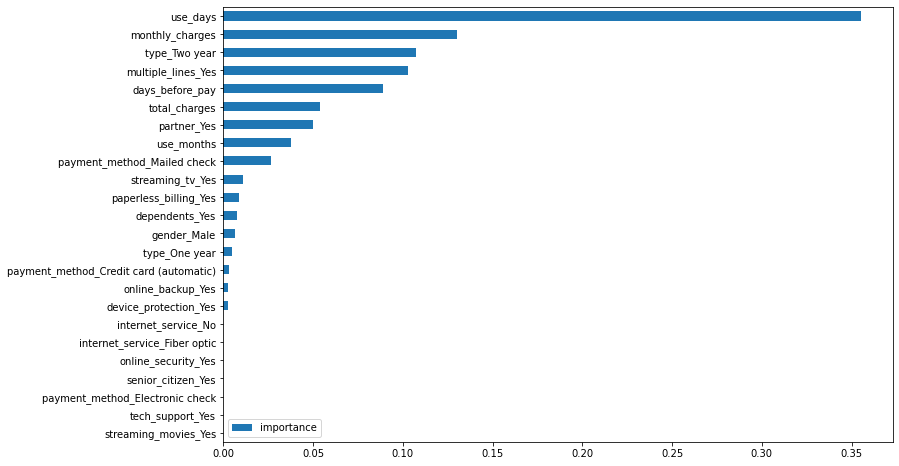

In [67]:
rf = DecisionTreeClassifier(max_depth=8, max_features=16,
                                        min_samples_leaf=24,
                                        random_state=200524)
rf.fit(X_train, y_train)
imp = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

**Самыми значимыми признаками являются: `use_days`, `monthly_charges`, `type_Two_year` и `multiple_lines_Yes`.**

### CatBoostClassifier.

In [68]:
start_time = time.time()
model = CatBoostClassifier(max_depth=4, random_state=200524, verbose=False)

param_grid = [

    {
        'learning_rate':[0.1, 0.3]
    }
]

cat_boost_gs = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

start_time = time.time()
cat_boost_gs.fit(X_train, y_train)
cbr_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % cbr_train_time)

roc_auc_model_catboost = round((cat_boost_gs.best_score_), 4)

print(f'Метрика на кросс-валидационной выборке: {roc_auc_model_catboost}')
print('Лучшая модель и её параметры:\n', cat_boost_gs.best_estimator_)
pd.DataFrame(cat_boost_gs.cv_results_)

---Время обучения модели 21.86274 секунд ---
Метрика на кросс-валидационной выборке: 0.9081
Лучшая модель и её параметры:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.968630,0.036892,0.004197,0.000599,0.1,{'learning_rate': 0.1},0.895183,0.900444,0.908139,0.903840,0.932959,0.908113,0.013127,1
1,1.945008,0.115073,0.004203,0.000573,0.3,{'learning_rate': 0.3},0.900883,0.900160,0.903591,0.902887,0.921110,0.905726,0.007794,2


### LGBMClassifier

In [69]:
start_time = time.time()
model = LGBMClassifier(random_state=200524)

param_grid = [

    {
        'learning_rate':[0.1]
    }
]
lgbm_gs = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

start_time = time.time()
lgbm_gs.fit(X_train, y_train)
lgbm_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % lgbm_train_time)

roc_auc_model_lgbm = round((lgbm_gs.best_score_), 4)

print(f'Метрика на кросс-валидационной выборке: {roc_auc_model_lgbm}')
print('Лучшая модель и её параметры:\n', lgbm_gs.best_estimator_)
pd.DataFrame(lgbm_gs.cv_results_)

---Время обучения модели 4.00121 секунд ---
Метрика на кросс-валидационной выборке: 0.858
Лучшая модель и её параметры:
 LGBMClassifier(random_state=200524)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.933327,0.044308,0.064957,0.041614,0.1,{'learning_rate': 0.1},0.844335,0.875881,0.853898,0.858038,0.013207,1


### Выбор лучшей модели.

In [70]:
data = [[roc_auc_lr_model],
        [roc_auc_model_tree],
        [roc_auc_model_catboost], 
        [roc_auc_model_lgbm]]
models = ['LogisticRegression', 'decision_tree_classifier', 'CatBoostClassifier', 'LGBMClassifier']
resume = pd.DataFrame(data=data, index=models, columns=['ROC_AUC']).sort_values(by='ROC_AUC', ascending=False)
resume

,ROC_AUC
CatBoostClassifier,0.9081
LGBMClassifier,0.8580
decision_tree_classifier,0.7853
LogisticRegression,0.7750


**Лучшей моделью стала `CatBoostClassifier` на ней и проверим тестовую выборку.**

In [71]:
pred = cat_boost_gs.best_estimator_.predict_proba(X_test)
predictions = cat_boost_gs.best_estimator_.predict(X_test)
roc_auc_cat_boost_model = roc_auc_score(y_test, pred[:,1])
precision_score = precision_score(y_test, predictions)
print(f'ROC_AUC лучшей модели на тестовой выборке = {roc_auc_cat_boost_model:.4f}')
print(f'Precision лучшей модели на тестовой выборке = {precision_score:.4f}')

ROC_AUC лучшей модели на тестовой выборке = 0.9433
Precision лучшей модели на тестовой выборке = 0.9330


**Метрика лучшей модели на тестовой выборке равна 0,9433. Неплохой результат.**

**Дополнительно посчитали метрику `Precision`, т.к нам важно как можно точнее определить клиентов, склонных к уходу. Метрика лучшей модели получилась равна 0.933.**

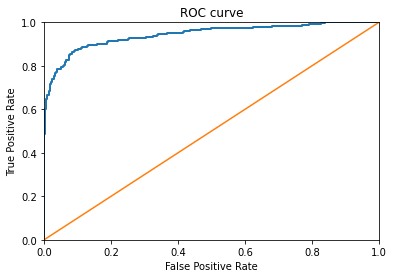

In [72]:
predicted_probalities = cat_boost_gs.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, predicted_probalities, pos_label=1)

lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

## Общий вывод.

**Нам было поручено обучить модель, которая предсказывала бы отток клиентов из компании Телеком. Было предоставлено 4 таблицы с данными о клиентах, интернет услугах и услугах телефонии. Мы загрузили датасеты, провели предобработку данных, после чего объединили все данные в один датафрейм. Выбран целевой параметр, датасет разделен на тренировочную и тестовую выборки. Выбрали 4 модели для решения задачи классификации и обучили их на тренировочном датасете. Лучшей моделью оказалась `CatBoostClassifier`, показавшая на тестовой выборке метрику ROC_AUC = 0.9433. Также определили топ-3 важных признака:  `use_days`, `monthly_charges`, `type_Two_year`.**

**Попытались составить портрет ушедшего клиента. У нас получилось, что чаще всего расторгают договор клиенты с включенными дополнительными опциями и клиенты с договорной оплатой на 1 и 2 года. Вдобавок график, отражающий общий сбор с ушедших и оставшихся клиентов показывает, что сегменте трат от 2000 до 4200 уходит, примерно, половина клиентов. Установили, что клиенты с продолжительностью контракта до 3 лет более склонны к уходу. Также график подтвердил, что людям не сильно нравится расставаться со своими деньгами, так вероятность ухода напрямую зависить от величины ежемесячных трат клиента. Предположу, что именно таким клиентам нужно выдавать промокоды или предоставлять специальные условия.**